## 1. Setup and Load Data

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,  True)

## 1.2 Remove dodgy images

In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')

Image not in ext list data\cat\vector.svg
Image not in ext list data\cat\vector2.svg
Image not in ext list data\cat\vector3.svg
Image not in ext list data\cat\vector4.svg
Image not in ext list data\cat\vector5.svg
Image not in ext list data\cat\vector6.svg
Image not in ext list data\cat\vector7.svg
Image not in ext list data\dog\vector.svg
Image not in ext list data\dog\vector2.svg
Image not in ext list data\dog\vector3.svg
Image not in ext list data\dog\vector4.svg
Image not in ext list data\dog\vector5.svg
Image not in ext list data\dog\vector6.svg
Image not in ext list data\dog\vector7.svg


In [8]:
img = cv2.imread(os.path.join('data', 'cat', 'image4.jpg'))

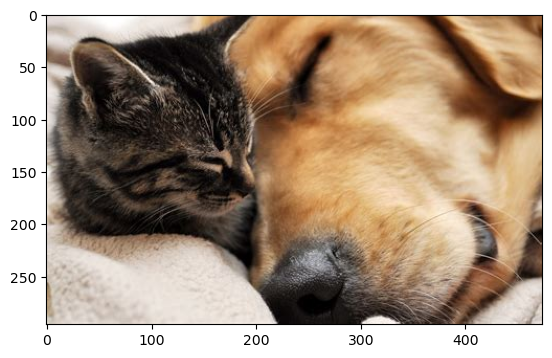

In [9]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 1.3 Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 593 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
batch[0].shape

(32, 256, 256, 3)

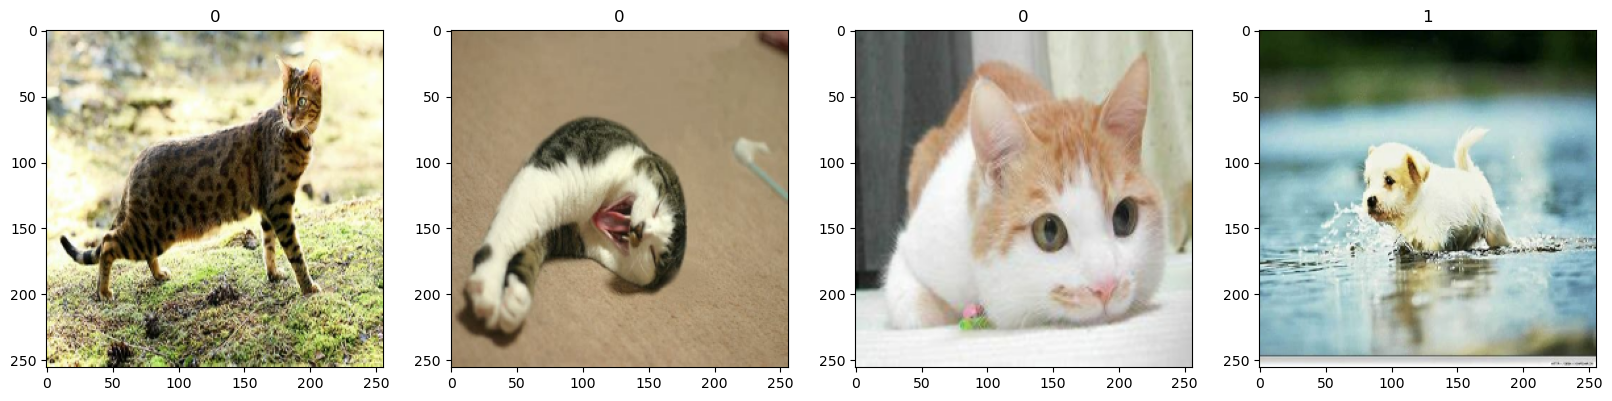

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Preprocess data

## 2.1 Scale Data

In [16]:
scaled_data = data.map(lambda image, label: (image/255, label))

In [17]:
scaled_data.as_numpy_iterator().next()[0].max()

1.0

## 2.2 Split Data

In [18]:
train_size = int(len(scaled_data)*.7) + 1
val_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1)

In [19]:
train = data.skip(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

## 3. Deep Model

## 3.1 Build Deep Learning Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Flatten the output before the fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

In [22]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                        

## 3.2 Train

In [24]:
logdir = 'logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

learning_rate_scheduler =  tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [26]:
history = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback, early_stopping_callback, learning_rate_scheduler])

Epoch 1/40
5/5 [==============================] - 6s 465ms/step - loss: 25.5460 - accuracy: 0.5517 - val_loss: 23.6733 - val_accuracy: 0.5729 - lr: 0.0010
Epoch 2/40
5/5 [==============================] - 1s 192ms/step - loss: 19.6439 - accuracy: 0.6828 - val_loss: 26.3002 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 3/40
5/5 [==============================] - 1s 210ms/step - loss: 21.0652 - accuracy: 0.6138 - val_loss: 18.9746 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 4/40
5/5 [==============================] - 1s 195ms/step - loss: 12.3665 - accuracy: 0.6138 - val_loss: 19.0165 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/40
5/5 [==============================] - 1s 212ms/step - loss: 11.7269 - accuracy: 0.6828 - val_loss: 18.6048 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 6/40
5/5 [==============================] - 1s 217ms/step - loss: 6.2625 - accuracy: 0.7379 - val_loss: 18.0573 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 7/40
5/5 [==============================] - 1s 193ms/step - loss:

## 3.3 Plot Performance

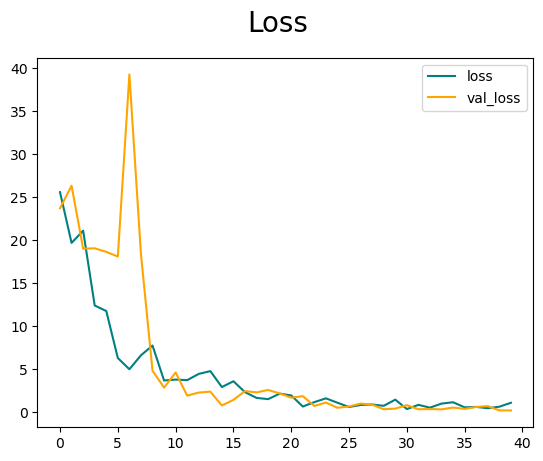

In [27]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

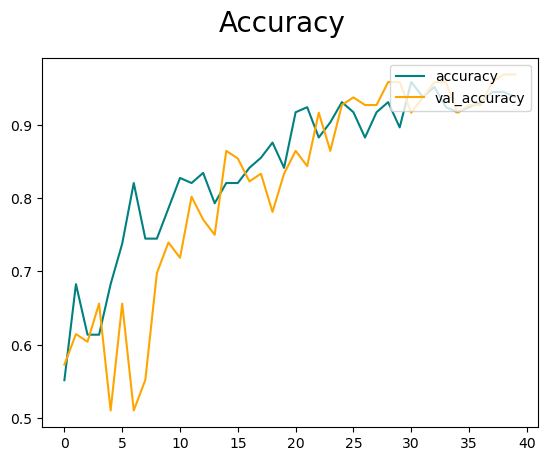

In [28]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

# 4. Evaluate Performance

## 4.1 Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

In [32]:
print(f"Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


## 4.2

In [39]:
import cv2

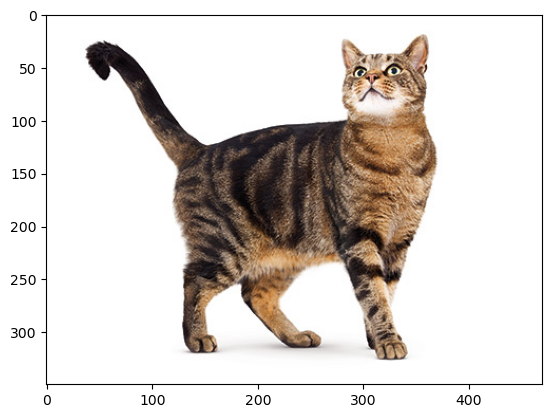

In [64]:
img = cv2.imread('cat.jpg')
recolored_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(recolored_image)
plt.show()

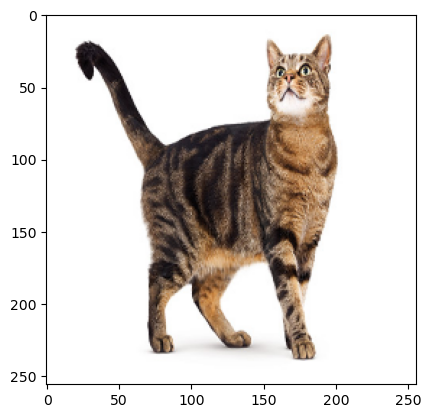

In [65]:
resize = tf.image.resize(recolored_image, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [66]:
yhat = model.predict(np.expand_dims(resize, 0))

In [67]:
yhat

array([[3.5416215e-05]], dtype=float32)

In [68]:
if yhat > 0.5:
    print("Predicted class is dog")
else:
    print("Predicted class is cat")

Predicted class is cat


## 5. Save The Model

## 5.1 Save The Model

In [69]:
from tensorflow.keras.models import load_model

In [70]:
model_name = "cat_dogs_classifier.h5"
model.save(os.path.join('models', model_name))

In [71]:
new_model = load_model(os.path.join('models', model_name))

In [72]:
yhat_new = new_model.predict(np.expand_dims(resize, 0))

In [73]:
if yhat_new > 0.5:
    print("Predicted class is dog")
else:
    print("Predicted class is cat")

Predicted class is cat
